# Part D Logistic Regression vs. Bayesian Classifier
## Question 4
This task assesses your analytical skills. You need to study the performance of two
well-known generative and discriminative models, i.e. Bayesian classifier and logistic
regression, as the size of the training set increases. Then, you show your understanding of
the behaviour of learning curves of typical generative and discriminative models.

In [1]:
require(ggplot2);
require(reshape2);

testData <- read.csv("C:/Users/aaron/OneDrive/Documents/Monash Data Science/Algorithms For Data Analysis/Assignment 2/Dataset/Task2D_test.csv")
testLabel <- testData[, 'y']
testData <- testData[, 1:2]
trainData <- read.csv("C:/Users/aaron/OneDrive/Documents/Monash Data Science/Algorithms For Data Analysis/Assignment 2/Dataset/Task2D_train.csv ")
trainLabel <- trainData[, 'y']
trainData <- trainData[, 1:2]


Loading required package: ggplot2
Loading required package: reshape2


In [2]:
bayesClassifier <- function(trainData, trainLabel, testData, testLabel, c0, c1) {

    require(mvtnorm)
    # recover data sets

    train.len <- round(nrow(trainData));
    train.data <- trainData;
    train.label <- trainLabel;

    test.data <- testData;
    test.label <- testLabel;

    # Class probabilities:
    p0.hat <- sum(train.label == c0) / nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label == c1) / nrow(train.data) # or simply 1 - p1.hat

    # Class means:
    mu0.hat <- colMeans(train.data[train.label == c0,])
    mu1.hat <- colMeans(train.data[train.label == c1,])

    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label == c0,])
    sigma1.hat <- var(train.data[train.label == c1,])


    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat

    # calculate posteriors:
    posterior0 <- p0.hat * dmvnorm(x = train.data, mean = mu0.hat, sigma = sigma.hat)
    posterior1 <- p1.hat * dmvnorm(x = train.data, mean = mu1.hat, sigma = sigma.hat)

    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat * dmvnorm(x = test.data, mean = mu0.hat, sigma = sigma.hat) > p1.hat * dmvnorm(x = test.data, mean = mu1.hat, sigma = sigma.hat), c0, c1)


    # calculate accuracy
    trAccuracy_ <- sum(train.label == train.predict) / nrow(train.data) * 100
    tsAccuracy_ <- sum(test.label == test.predict) / nrow(test.data) * 100

    # Confusion Matix (Train):
    cmTrain_ <- table(train.label, train.predict)

    # Confusion Matix (Test):
    cmTest_ <- table(test.label, test.predict)

    res_ <- list("TrainingError" = 100 - trAccuracy_, "TestError" = 100 - tsAccuracy_);

    return(res_);
}


In [3]:
logisticClassifier <- function(trainData, trainLabel, testData, testLabel, c0, c1, iterMax = 1000, eta = 0.01, epsilon = 0.01) {

    library(mvtnorm)

    train.len <- round(nrow(trainData));
    train.data <- trainData;
    train.label <- trainLabel;

    test.data <- testData;
    test.label <- testLabel;


    # auxiliary function that predicts class labels
    predict <- function(w, X, c0, c1) {
        sig <- sigmoid(w, X)
        return(ifelse(sig > 0.5, c1, c0))
    }

    # auxiliary function that calculate a cost function
    cost <- function(w, X, T, c0) {
        sig <- sigmoid(w, X)
        return(sum(ifelse(T == c0, 1 - sig, sig)))
    }

    # Sigmoid function (=p(C1|X))
    sigmoid <- function(w, x) {
        return(1.0 / (1.0 + exp( - w %*% t(cbind(1, x)))))
    }

    # Initializations
    tau.max <- iterMax # maximum number of iterations
    eta <- eta # learning rate
    epsilon <- epsilon # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label == c0, 0, 1) # rename just for conviniance

    W <- matrix(, nrow = tau.max, ncol = (ncol(X) + 1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,], X)

    costs <- data.frame('tau' = 1:tau.max) # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,], X, T, c0)

    while (!terminate) {
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,], X, T, c0) <= epsilon

        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        # for each datapoint:
        for (i in 1:train.len) {
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau, ], X, T, c0) <= epsilon) {
                terminate <- TRUE;
                break
            }

            Y <- sigmoid(W[tau,], X)

            # Update the weights
            W[(tau + 1),] <- W[tau,] - eta * (Y[i] - T[i]) * cbind(1, t(X[1,]))

            # record the cost:
            costs[(tau + 1), 'cost'] <- cost(W[tau,], X, T, c0)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }

    costs <- costs[1:tau,] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[tau,]

    # make predictions on test and train set
    trPreds_ <- predict(W[tau,], as.matrix(train.data), c0, c1);
    tsPreds_ <- predict(W[tau,], as.matrix(test.data), c0, c1);

    # compare the number of missclassifications
    trError_ <- sum(trPreds_ != train.label) / length(train.label);
    tsError_ <- sum(tsPreds_ != test.label) / length(test.label);

    res_ <- list("Costs" = costs, "Coefficients" = w, "TrainingError" = trError_ * 100, "TestError" = tsError_ * 100);

    return(res_);
}


Loading required package: mvtnorm


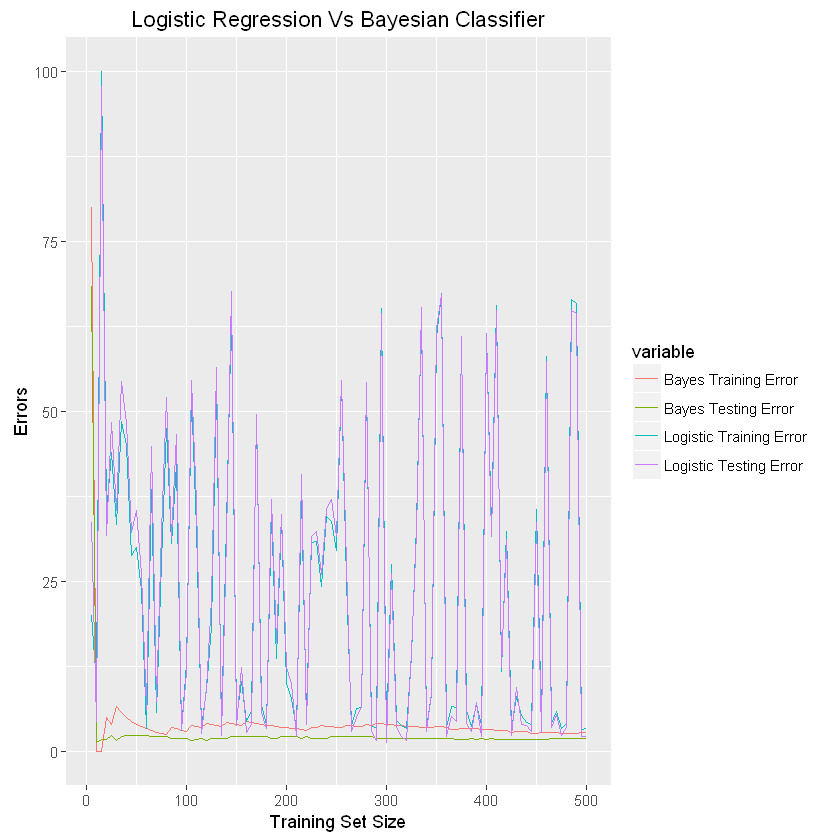

In [4]:
# loop through increasing size from 5 - length of training set.
seq_ <- seq(5, nrow(trainData), 5);

errMatrix_ <- matrix(, length(seq_), ncol = 4);

iter_ <- 1;

for (i in seq_) {

    # apply bayes classifer
    nb_ <- bayesClassifier(trainData[1:i,], trainLabel[1:i], testData, testLabel, 1, -1);

    # record error
    errMatrix_[iter_, 1] <- nb_$TrainingError;
    errMatrix_[iter_, 2] <- nb_$TestError;

    # apply logistic regression
    lr_ <- logisticClassifier(trainData[1:i,], trainLabel[1:i], testData, testLabel, 1, -1);

    # record error
    errMatrix_[iter_, 3] <- lr_$TrainingError;
    errMatrix_[iter_, 4] <- lr_$TestError;

   
    iter_ <- iter_ + 1;

}

df_ <- as.data.frame(cbind(seq_, errMatrix_));

colnames(df_) <- c("DataLength", "Bayes Training Error", "Bayes Testing Error", "Logistic Training Error", "Logistic Testing Error");

df_M <- melt(df_, id = "DataLength")

ggplot(data = df_M, aes(x = DataLength, y = value, color = variable)) + geom_line() + xlab("Training Set Size") + ylab("Errors") + ggtitle("Logistic Regression Vs Bayesian Classifier");